In [2]:
import numpy as np
import pandas as pd
import pylab as pl
import geopandas as gpd
import os
import io
import requests
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
from matplotlib import gridspec
from fiona.crs import from_epsg
import shapely
import seaborn as sns
from datetime import datetime
#import choroplethNYC as cp

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\sherr\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Data Collection

Exoplore the taxi zone and location ID

In [98]:
taxiZone = gpd.GeoDataFrame.from_file("taxi_zones/taxi_zones.shp")

In [99]:
taxiZone[taxiZone['zone'] == 'LaGuardia Airport']

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
137,138,0.107467,0.000537,LaGuardia Airport,138,Queens,(POLYGON ((1019904.218994156 225677.9833984375...


Download 2018 yellow taxi data and save those end at LGA.

In [ ]:
all_data = pd.DataFrame()

for i in range(1,10):
    url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-0' + str(i) + '.csv'
    s = requests.get(url).content
    c = pd.read_csv(io.StringIO(s.decode('utf-8')))
    c = c[c['DOLocationID'] == 138]
    print(i)
    all_data = pd.concat([all_data, c])

In [ ]:
for i in range(11,13):
    url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-' + str(i) + '.csv'
    s = requests.get(url).content
    c = pd.read_csv(io.StringIO(s.decode('utf-8')))
    c = c[c['DOLocationID'] == 138]
    print(i)
    all_data = pd.concat([all_data, c])

In [ ]:
all_data.shape

In [ ]:
all_data.to_csv('lga2018.csv')

## Data Cleaning

In [3]:
lgaTaxi = pd.read_csv("lga2018.csv")

In [4]:
lgaTaxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2018/1/1 0:57,2018/1/1 1:43,2,9.29,5,N,100,138,1,70.0,0.0,0.0,0.00,0.0,0.3,70.30
1,1,2018/1/1 0:26,2018/1/1 0:51,2,9.50,1,N,161,138,2,30.0,0.5,0.5,0.00,0.0,0.3,31.30
2,2,2018/1/1 0:53,2018/1/1 1:07,6,11.36,1,N,132,138,1,30.5,0.5,0.5,0.02,0.0,0.3,31.82
3,2,2017/12/31 23:29,2017/12/31 23:34,1,1.29,1,N,138,138,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30
4,1,2018/1/1 0:41,2018/1/1 1:18,1,10.50,1,N,170,138,2,36.5,0.5,0.5,0.00,0.0,0.3,37.80


drop data which pick up date before 2018, keep the data which drop off date after 2018.

We use the pick up data to locate its weather factor.

In [5]:
lgaTaxi['tpep_pickup_datetime'] = pd.to_datetime(lgaTaxi['tpep_pickup_datetime'])
lgaTaxi['tpep_dropoff_datetime'] = pd.to_datetime(lgaTaxi['tpep_dropoff_datetime'])

In [6]:
lgaTaxi.shape

(1038328, 17)

In [7]:
lgaTaxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2018-01-01 00:57:00,2018-01-01 01:43:00,2,9.29,5,N,100,138,1,70.0,0.0,0.0,0.00,0.0,0.3,70.30
1,1,2018-01-01 00:26:00,2018-01-01 00:51:00,2,9.50,1,N,161,138,2,30.0,0.5,0.5,0.00,0.0,0.3,31.30
2,2,2018-01-01 00:53:00,2018-01-01 01:07:00,6,11.36,1,N,132,138,1,30.5,0.5,0.5,0.02,0.0,0.3,31.82
3,2,2017-12-31 23:29:00,2017-12-31 23:34:00,1,1.29,1,N,138,138,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30
4,1,2018-01-01 00:41:00,2018-01-01 01:18:00,1,10.50,1,N,170,138,2,36.5,0.5,0.5,0.00,0.0,0.3,37.80


In [8]:
lgaTaxi = lgaTaxi[lgaTaxi['tpep_pickup_datetime'] > '2018-01-01']
lgaTaxi.reset_index(drop = True, inplace = True)

In [9]:
sum(lgaTaxi['tpep_dropoff_datetime'] > '2018-12-31')

1081

### Get the trip time and trip distance feature

In [10]:
lgaTaxi.shape

(1038313, 17)

In [11]:
lgaTaxi['trip_time'] = (lgaTaxi['tpep_dropoff_datetime'] - lgaTaxi['tpep_pickup_datetime']).apply(lambda x: x.seconds/60).tolist()

In [12]:
lgaTaxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time
0,2,2018-01-01 00:57:00,2018-01-01 01:43:00,2,9.29,5,N,100,138,1,70.0,0.0,0.0,0.00,0.00,0.3,70.30,46
1,1,2018-01-01 00:26:00,2018-01-01 00:51:00,2,9.50,1,N,161,138,2,30.0,0.5,0.5,0.00,0.00,0.3,31.30,25
2,2,2018-01-01 00:53:00,2018-01-01 01:07:00,6,11.36,1,N,132,138,1,30.5,0.5,0.5,0.02,0.00,0.3,31.82,14
3,1,2018-01-01 00:41:00,2018-01-01 01:18:00,1,10.50,1,N,170,138,2,36.5,0.5,0.5,0.00,0.00,0.3,37.80,37
4,1,2018-01-01 00:10:00,2018-01-01 00:49:00,1,21.30,1,N,68,138,3,57.5,0.5,0.5,0.00,5.76,0.3,64.56,39


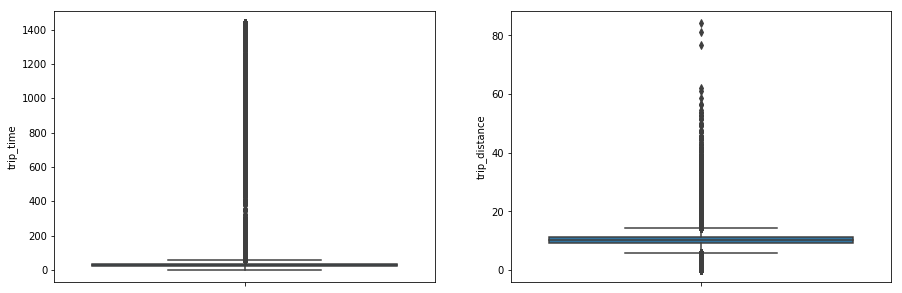

In [13]:
f, (ax1, ax2) =pl.subplots(1, 2, figsize=(15,5))
sns.boxplot(y='trip_time',data=lgaTaxi, ax=ax1)
sns.boxplot(y='trip_distance',data=lgaTaxi, ax=ax2)

Text(0.5,1,'trip_distance')

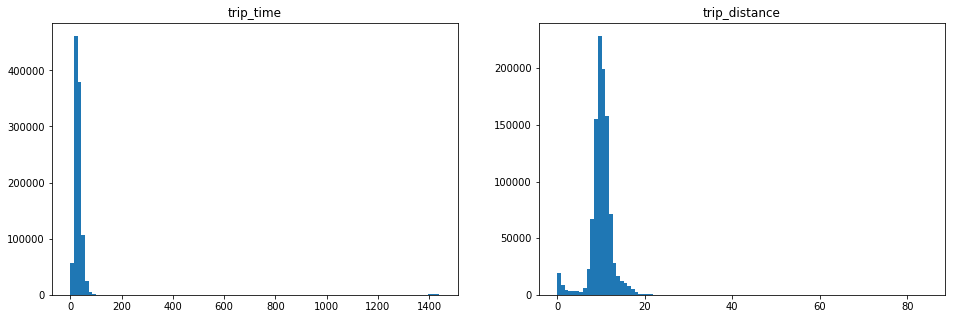

In [14]:
#a = hist(lagTaxi['trip_time'], bins=100)

figure(figsize=(16,5))
pl.subplot(121)
hist(lgaTaxi['trip_time'], bins=100)
pl.title("trip_time")

pl.subplot(122)
hist(lgaTaxi['trip_distance'], bins=100)
pl.title("trip_distance")

In [15]:
def outlier(df, row):
    #display(df[np.abs(df[row] - df[row].mean())> 3*df[row].std()])
    print(df[row].mean()-3*df[row].std(), df[row].mean()+3*df[row].std())
    return(df[-(np.abs(df[row] - df[row].mean())> 3*df[row].std())])

In [16]:
lgaTaxiClean1 = outlier(lgaTaxi, "trip_time")
lgaTaxiClean2 = outlier(lgaTaxi, "trip_distance")

lgaTaxiClean3 = outlier(lgaTaxi, "trip_time")
lgaTaxiClean3 = outlier(lgaTaxiClean3, "trip_distance")

(-205.46459788174923, 275.2635910562544)
(2.251560099982786, 17.873611173033016)
(-205.46459788174923, 275.2635910562544)
(2.2524017182765226, 17.868642046745723)


Text(0.5,1,'trip_distance')

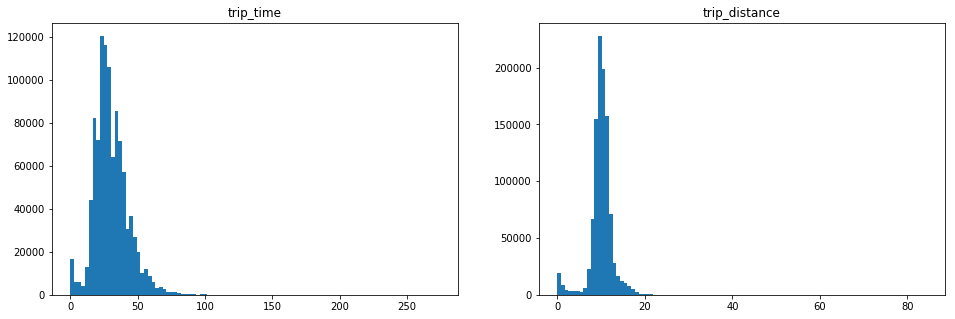

In [17]:
figure(figsize=(16,5))
pl.subplot(121)
hist(lgaTaxiClean1['trip_time'], bins=100)
pl.title("trip_time")

pl.subplot(122)
hist(lgaTaxiClean1['trip_distance'], bins=100)
pl.title("trip_distance")

Text(0.5,1,'trip_distance')

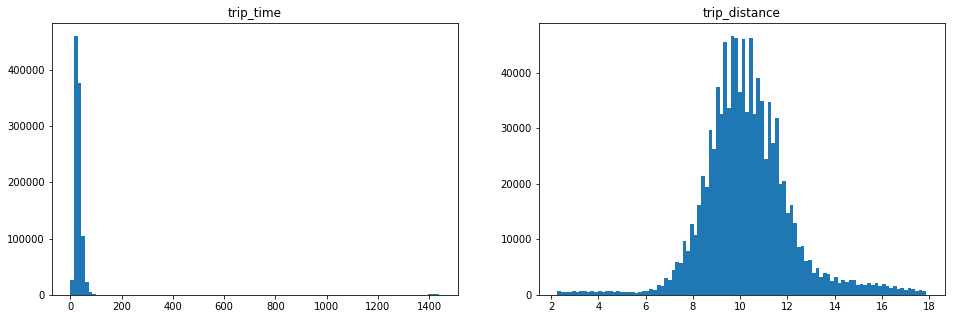

In [18]:
figure(figsize=(16,5))
pl.subplot(121)
hist(lgaTaxiClean2['trip_time'], bins=100)
pl.title("trip_time")

pl.subplot(122)
hist(lgaTaxiClean2['trip_distance'], bins=100)
pl.title("trip_distance")

Text(0.5,1,'trip_distance')

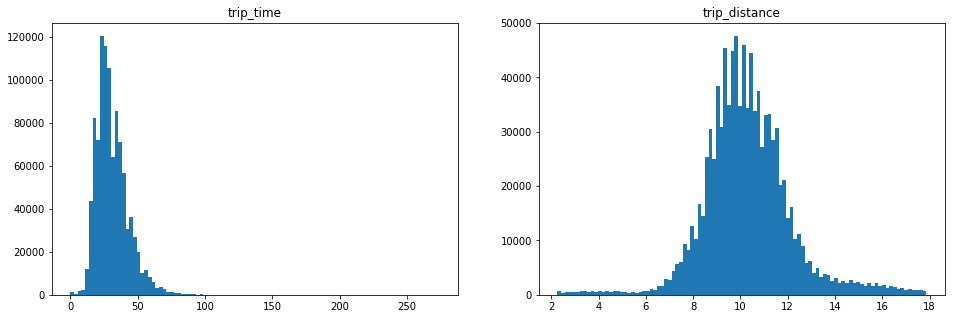

In [19]:
figure(figsize=(16,5))
pl.subplot(121)
hist(lgaTaxiClean3['trip_time'], bins=100)
pl.title("trip_time")

pl.subplot(122)
hist(lgaTaxiClean3['trip_distance'], bins=100)
pl.title("trip_distance")

In [20]:
lgaTaxiClean4 = lgaTaxi[lgaTaxi['trip_time']<150]
lgaTaxiClean4 = lgaTaxiClean4[lgaTaxiClean4['trip_distance']<25]

Text(0.5,1,'trip_distance')

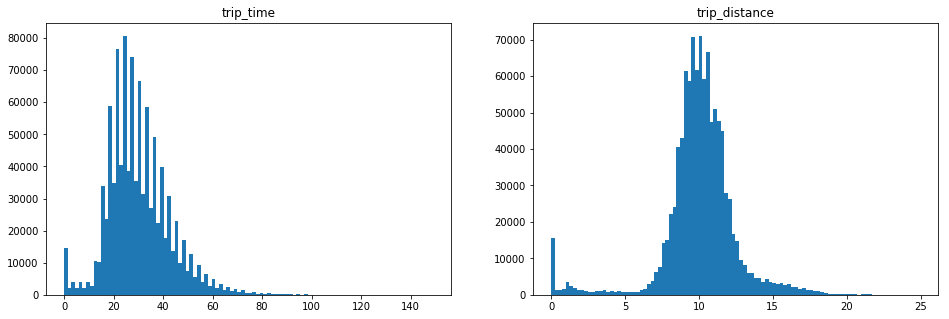

In [21]:
figure(figsize=(16,5))
pl.subplot(121)
hist(lgaTaxiClean4['trip_time'], bins=100)
pl.title("trip_time")

pl.subplot(122)
hist(lgaTaxiClean4['trip_distance'], bins=100)
pl.title("trip_distance")

drop data near 0 (unusual data)

trip_time<5 and trip_distance<1

In [22]:
lgaTaxiClean = lgaTaxiClean4[lgaTaxiClean4['trip_time']>5]
lgaTaxiClean = lgaTaxiClean[lgaTaxiClean['trip_distance']>1]

Text(0.5,1,'trip_distance')

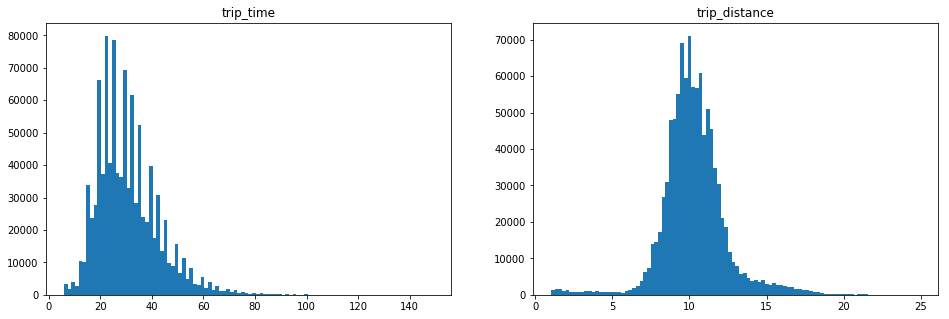

In [23]:
figure(figsize=(16,5))
pl.subplot(121)
hist(lgaTaxiClean['trip_time'], bins=100)
pl.title("trip_time")

pl.subplot(122)
hist(lgaTaxiClean['trip_distance'], bins=100)
pl.title("trip_distance")

In [24]:
lgaTaxiClean.reset_index(drop = True, inplace = True)

### feature --- pick up time, build day/hour id

We only consider about the factor when taxi picks up the passenger.

In [25]:
lgaTaxiClean['pickup_month'] = (lgaTaxiClean['tpep_pickup_datetime']).apply(lambda x: x.month).tolist()
lgaTaxiClean['pickup_day'] = (lgaTaxiClean['tpep_pickup_datetime']).apply(lambda x: x.day).tolist()
lgaTaxiClean['pickup_hour'] = (lgaTaxiClean['tpep_pickup_datetime']).apply(lambda x: x.hour).tolist()
lgaTaxiClean['pickup_minute'] = (lgaTaxiClean['tpep_pickup_datetime']).apply(lambda x: x.minute).tolist()

In [27]:
from datetime import datetime
lgaTaxiClean['day_id'] = (lgaTaxiClean['tpep_pickup_datetime']).apply(lambda x: (x - datetime.strptime('2018-01-01',  "%Y-%M-%d")).days).tolist()

In [28]:
lgaTaxiClean['hour_id'] = (lgaTaxiClean['tpep_pickup_datetime']).apply(lambda x: ((x - datetime.strptime('2018-01-01',  "%Y-%M-%d")).days)*24 + (x - datetime.strptime('2018-01-01',  "%Y-%M-%d")).seconds/3600).tolist()

In [29]:
lgaTaxiClean.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,pickup_month,pickup_day,pickup_hour,pickup_minute,day_id,hour_id
1009173,2,2018-12-31 21:02:00,2018-12-31 21:24:00,1,11.62,1,N,132,138,1,32.0,0.5,0.5,3.0,0.0,0.3,36.3,22,12,31,21,2,364,8757
1009174,2,2018-12-31 22:11:00,2018-12-31 22:29:00,1,2.68,1,N,138,138,2,12.0,0.5,0.5,0.0,0.0,0.3,13.3,18,12,31,22,11,364,8758
1009175,2,2018-12-31 23:18:00,2018-12-31 23:37:00,5,11.51,1,N,132,138,1,31.5,0.5,0.5,8.2,0.0,0.3,41.0,19,12,31,23,18,364,8759
1009176,2,2018-12-31 23:04:00,2018-12-31 23:42:00,2,9.39,1,N,92,138,1,32.0,0.5,0.5,0.0,0.0,0.3,33.3,38,12,31,23,4,364,8759
1009177,1,2018-12-31 23:54:00,2019-01-01 00:29:00,1,15.40,1,N,233,138,2,42.5,0.5,0.5,0.0,0.0,0.3,43.8,35,12,31,23,54,364,8759


### feature --- traffic

perious hour/2 hour ago/yesterday --- base on the pick up location ID

In [30]:
lgaTaxiClean['location_day_id'] = list(zip(lgaTaxiClean.PULocationID,lgaTaxiClean.day_id))
lgaTaxiClean['location_hour_id'] = list(zip(lgaTaxiClean.PULocationID,lgaTaxiClean.hour_id))

In [31]:
lgaTaxiClean.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,pickup_month,pickup_day,pickup_hour,pickup_minute,day_id,hour_id,location_day_id,location_hour_id
0,2,2018-01-01 00:57:00,2018-01-01 01:43:00,2,9.29,5,N,100,138,1,70.0,0.0,0.0,0.00,0.00,0.3,70.30,46,1,1,0,57,0,0,"(100, 0)","(100, 0)"
1,1,2018-01-01 00:26:00,2018-01-01 00:51:00,2,9.50,1,N,161,138,2,30.0,0.5,0.5,0.00,0.00,0.3,31.30,25,1,1,0,26,0,0,"(161, 0)","(161, 0)"
2,2,2018-01-01 00:53:00,2018-01-01 01:07:00,6,11.36,1,N,132,138,1,30.5,0.5,0.5,0.02,0.00,0.3,31.82,14,1,1,0,53,0,0,"(132, 0)","(132, 0)"
3,1,2018-01-01 00:41:00,2018-01-01 01:18:00,1,10.50,1,N,170,138,2,36.5,0.5,0.5,0.00,0.00,0.3,37.80,37,1,1,0,41,0,0,"(170, 0)","(170, 0)"
4,1,2018-01-01 00:10:00,2018-01-01 00:49:00,1,21.30,1,N,68,138,3,57.5,0.5,0.5,0.00,5.76,0.3,64.56,39,1,1,0,10,0,0,"(68, 0)","(68, 0)"


In [32]:
lgaTaxiClean.shape

(1009178, 26)

build daily per location ID trip duration

In [35]:
dailyTripDuration = lgaTaxiClean.groupby(['PULocationID', 'day_id']).mean()

In [36]:
dailyTripDuration.reset_index(inplace = True)

In [37]:
dailyTripDuration.head()

,PULocationID,day_id,VendorID,passenger_count,trip_distance,RatecodeID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,pickup_month,pickup_day,pickup_hour,pickup_minute,hour_id
0,1,82,1.0,1.0,23.5,5.0,138.0,1.0,131.0,0.0,0.0,28.85,13.0,0.3,173.15,47.0,3.0,24.0,8.0,52.0,1976.0
1,1,179,2.0,1.0,24.7,1.0,138.0,1.0,72.0,0.0,0.5,21.84,0.0,0.3,94.64,60.0,6.0,29.0,11.0,13.0,4307.0
2,1,338,1.0,1.0,24.9,1.0,138.0,1.0,98.0,1.0,0.5,19.95,0.0,0.3,119.75,112.0,12.0,5.0,17.0,0.0,8128.0
3,1,353,1.0,2.0,22.7,1.0,138.0,1.0,70.5,0.0,0.5,16.36,10.5,0.3,98.16,68.0,12.0,20.0,11.0,28.0,8483.0
4,2,199,1.0,2.0,11.7,1.0,138.0,2.0,36.0,0.0,0.5,0.00,0.0,0.3,36.80,33.0,7.0,19.0,9.0,34.0,4785.0


In [38]:
dailyTripDuration['yesterday_id'] = dailyTripDuration['day_id'] + 1

In [39]:
dailyTripDuration['location_yesterday_id'] = list(zip(dailyTripDuration.PULocationID,dailyTripDuration.yesterday_id))

In [40]:
dailyTripDuration = dailyTripDuration[['trip_time', 'location_yesterday_id']]
dailyTripDuration.rename(columns={dailyTripDuration.columns[0]: "yesterday_avg_trip_time" }, inplace=True)

In [41]:
dailyTripDuration.head()

,yesterday_avg_trip_time,location_yesterday_id
0,47.0,"(1, 83)"
1,60.0,"(1, 180)"
2,112.0,"(1, 339)"
3,68.0,"(1, 354)"
4,33.0,"(2, 200)"


In [42]:
lgaTaxiClean = lgaTaxiClean.merge(dailyTripDuration, left_on = 'location_day_id', right_on = 'location_yesterday_id', how = 'left')

In [43]:
lgaTaxiClean.dropna(inplace = True)
lgaTaxiClean.reset_index(drop = True, inplace = True)

In [44]:
lgaTaxiClean.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,pickup_month,pickup_day,pickup_hour,pickup_minute,day_id,hour_id,location_day_id,location_hour_id,yesterday_avg_trip_time,location_yesterday_id
0,2,2018-01-02 00:20:00,2018-01-02 00:46:00,2,8.65,1,N,186,138,2,27.5,0.5,0.5,0.00,0.00,0.3,28.80,26,1,2,0,20,1,24,"(186, 1)","(186, 24)",22.855072,"(186, 1)"
1,2,2018-01-02 00:12:00,2018-01-02 00:37:00,1,10.84,1,N,158,138,1,31.5,0.5,0.5,11.57,5.76,0.3,50.13,25,1,2,0,12,1,24,"(158, 1)","(158, 24)",30.125000,"(158, 1)"
2,1,2018-01-02 01:25:00,2018-01-02 01:47:00,1,11.10,1,N,142,138,2,32.0,0.5,0.5,0.00,5.76,0.3,39.06,22,1,2,1,25,1,25,"(142, 1)","(142, 25)",24.842105,"(142, 1)"
3,2,2018-01-02 02:21:00,2018-01-02 02:38:00,3,9.54,1,N,230,138,1,27.5,0.5,0.5,8.64,5.76,0.3,43.20,17,1,2,2,21,1,26,"(230, 1)","(230, 26)",25.372822,"(230, 1)"
4,2,2018-01-02 02:37:00,2018-01-02 02:56:00,3,9.55,1,N,68,138,2,27.5,0.5,0.5,0.00,5.76,0.3,34.56,19,1,2,2,37,1,26,"(68, 1)","(68, 26)",24.120000,"(68, 1)"


build hourly per location ID trip duration

perious hour/2 hour ago

In [45]:
hourlyTripDuration = lgaTaxiClean.groupby(['PULocationID', 'hour_id']).mean()
hourlyTripDuration.reset_index(inplace = True)

In [46]:
hourlyTripDuration.head()

,PULocationID,hour_id,VendorID,passenger_count,trip_distance,RatecodeID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,pickup_month,pickup_day,pickup_hour,pickup_minute,day_id,yesterday_avg_trip_time
0,4,40,1.5,1.0,12.38,1.0,138.0,1.5,40.0,1.0,0.5,4.675,2.88,0.3,49.355,41.5,1.0,2.0,16.0,27.0,1.0,19.333333
1,4,125,1.0,1.0,10.10,1.0,138.0,1.0,29.5,0.5,0.5,6.150,0.00,0.3,36.950,20.0,1.0,6.0,5.0,29.0,5.0,19.000000
2,4,127,2.0,5.0,10.00,1.0,138.0,1.0,29.5,0.0,0.5,7.000,0.00,0.3,37.300,21.0,1.0,6.0,7.0,54.0,5.0,19.000000
3,4,136,2.0,2.0,10.26,1.0,138.0,1.0,31.0,0.0,0.5,7.510,5.76,0.3,45.070,27.0,1.0,6.0,16.0,56.0,5.0,19.000000
4,4,147,2.0,1.0,10.09,1.0,138.0,1.0,29.5,0.5,0.5,6.160,0.00,0.3,36.960,18.0,1.0,7.0,3.0,59.0,6.0,22.666667


In [47]:
hourlyTripDuration['perious_hour_id'] = hourlyTripDuration['hour_id'] + 1
hourlyTripDuration['two_hour_ago_id'] = hourlyTripDuration['hour_id'] + 2

In [48]:
hourlyTripDuration['location_perious_hour_id'] = list(zip(hourlyTripDuration.PULocationID,hourlyTripDuration.perious_hour_id))
hourlyTripDuration['location_two_hour_ago_id'] = list(zip(hourlyTripDuration.PULocationID,hourlyTripDuration.two_hour_ago_id))

In [49]:
hourlyTripDuration = hourlyTripDuration[['trip_time', 'location_perious_hour_id', 'location_two_hour_ago_id']]
hourlyTripDuration.rename(columns={hourlyTripDuration.columns[0]: "perious_hour_avg_trip_time" }, inplace=True)

In [50]:
hourlyTripDuration.head()

,perious_hour_avg_trip_time,location_perious_hour_id,location_two_hour_ago_id
0,41.5,"(4, 41)","(4, 42)"
1,20.0,"(4, 126)","(4, 127)"
2,21.0,"(4, 128)","(4, 129)"
3,27.0,"(4, 137)","(4, 138)"
4,18.0,"(4, 148)","(4, 149)"


In [51]:
lgaTaxiClean = lgaTaxiClean.merge(hourlyTripDuration, left_on = 'location_hour_id', right_on = 'location_perious_hour_id', how = 'left')

In [52]:
hourlyTripDuration.rename(columns={hourlyTripDuration.columns[0]: "two_hour_ago_avg_trip_time" }, inplace=True)

In [53]:
hourlyTripDuration.head()

,two_hour_ago_avg_trip_time,location_perious_hour_id,location_two_hour_ago_id
0,41.5,"(4, 41)","(4, 42)"
1,20.0,"(4, 126)","(4, 127)"
2,21.0,"(4, 128)","(4, 129)"
3,27.0,"(4, 137)","(4, 138)"
4,18.0,"(4, 148)","(4, 149)"


In [54]:
lgaTaxiClean = lgaTaxiClean.merge(hourlyTripDuration, left_on = 'location_hour_id', right_on = 'location_two_hour_ago_id', how = 'left')

In [55]:
lgaTaxiClean.dropna(inplace = True)
lgaTaxiClean.reset_index(drop = True, inplace = True)

In [56]:
lgaTaxiClean.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,pickup_month,pickup_day,pickup_hour,pickup_minute,day_id,hour_id,location_day_id,location_hour_id,yesterday_avg_trip_time,location_yesterday_id,perious_hour_avg_trip_time,location_perious_hour_id_x,location_two_hour_ago_id_x,two_hour_ago_avg_trip_time,location_perious_hour_id_y,location_two_hour_ago_id_y
0,2,2018-01-02 04:49:00,2018-01-02 05:13:00,6,11.52,1,N,100,138,2,34.5,0.5,0.5,0.00,5.76,0.3,41.56,24,1,2,4,49,1,28,"(100, 1)","(100, 28)",23.121212,"(100, 1)",21.0,"(100, 28)","(100, 29)",17.0,"(100, 27)","(100, 28)"
1,2,2018-01-02 04:41:00,2018-01-02 05:02:00,5,8.99,1,N,170,138,1,28.0,0.5,0.5,7.01,5.76,0.3,42.07,21,1,2,4,41,1,28,"(170, 1)","(170, 28)",19.730159,"(170, 1)",20.0,"(170, 28)","(170, 29)",17.0,"(170, 27)","(170, 28)"
2,2,2018-01-02 04:38:00,2018-01-02 04:53:00,1,8.67,1,N,170,138,1,25.0,0.5,0.5,6.41,5.76,0.3,38.47,15,1,2,4,38,1,28,"(170, 1)","(170, 28)",19.730159,"(170, 1)",20.0,"(170, 28)","(170, 29)",17.0,"(170, 27)","(170, 28)"
3,1,2018-01-02 04:15:00,2018-01-02 04:40:00,2,12.20,1,N,230,138,2,35.0,0.5,0.5,0.00,5.76,0.3,42.06,25,1,2,4,15,1,28,"(230, 1)","(230, 28)",25.372822,"(230, 1)",20.5,"(230, 28)","(230, 29)",17.0,"(230, 27)","(230, 28)"
4,2,2018-01-02 04:39:00,2018-01-02 05:02:00,2,7.99,1,N,48,138,1,25.5,0.5,0.5,6.70,0.00,0.3,33.50,23,1,2,4,39,1,28,"(48, 1)","(48, 28)",26.047619,"(48, 1)",21.0,"(48, 28)","(48, 29)",23.0,"(48, 27)","(48, 28)"


In [57]:
lgaTaxiClean.shape

(813512, 34)

### feature --- hoilday

is weekday, is Friday, is hoilday, is the day before/after hoilday

Friday, weekday

In [58]:
lgaTaxiClean['week'] = lgaTaxiClean['tpep_pickup_datetime'].apply(lambda x: x.weekday()).tolist()

In [59]:
lgaTaxiClean.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,pickup_month,pickup_day,pickup_hour,pickup_minute,day_id,hour_id,location_day_id,location_hour_id,yesterday_avg_trip_time,location_yesterday_id,perious_hour_avg_trip_time,location_perious_hour_id_x,location_two_hour_ago_id_x,two_hour_ago_avg_trip_time,location_perious_hour_id_y,location_two_hour_ago_id_y,week
0,2,2018-01-02 04:49:00,2018-01-02 05:13:00,6,11.52,1,N,100,138,2,34.5,0.5,0.5,0.00,5.76,0.3,41.56,24,1,2,4,49,1,28,"(100, 1)","(100, 28)",23.121212,"(100, 1)",21.0,"(100, 28)","(100, 29)",17.0,"(100, 27)","(100, 28)",1
1,2,2018-01-02 04:41:00,2018-01-02 05:02:00,5,8.99,1,N,170,138,1,28.0,0.5,0.5,7.01,5.76,0.3,42.07,21,1,2,4,41,1,28,"(170, 1)","(170, 28)",19.730159,"(170, 1)",20.0,"(170, 28)","(170, 29)",17.0,"(170, 27)","(170, 28)",1
2,2,2018-01-02 04:38:00,2018-01-02 04:53:00,1,8.67,1,N,170,138,1,25.0,0.5,0.5,6.41,5.76,0.3,38.47,15,1,2,4,38,1,28,"(170, 1)","(170, 28)",19.730159,"(170, 1)",20.0,"(170, 28)","(170, 29)",17.0,"(170, 27)","(170, 28)",1
3,1,2018-01-02 04:15:00,2018-01-02 04:40:00,2,12.20,1,N,230,138,2,35.0,0.5,0.5,0.00,5.76,0.3,42.06,25,1,2,4,15,1,28,"(230, 1)","(230, 28)",25.372822,"(230, 1)",20.5,"(230, 28)","(230, 29)",17.0,"(230, 27)","(230, 28)",1
4,2,2018-01-02 04:39:00,2018-01-02 05:02:00,2,7.99,1,N,48,138,1,25.5,0.5,0.5,6.70,0.00,0.3,33.50,23,1,2,4,39,1,28,"(48, 1)","(48, 28)",26.047619,"(48, 1)",21.0,"(48, 28)","(48, 29)",23.0,"(48, 27)","(48, 28)",1


In [60]:
lgaTaxiClean['if_Friday'] = lgaTaxiClean['week'].apply(lambda x: 1 if x == 4 else 0).tolist()

In [61]:
lgaTaxiClean['if_weekend'] = lgaTaxiClean['week'].apply(lambda x: 1 if x == 5 or x == 6 else 0).tolist()

In [62]:
lgaTaxiClean.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,pickup_month,pickup_day,pickup_hour,pickup_minute,day_id,hour_id,location_day_id,location_hour_id,yesterday_avg_trip_time,location_yesterday_id,perious_hour_avg_trip_time,location_perious_hour_id_x,location_two_hour_ago_id_x,two_hour_ago_avg_trip_time,location_perious_hour_id_y,location_two_hour_ago_id_y,week,if_Friday,if_weekend
0,2,2018-01-02 04:49:00,2018-01-02 05:13:00,6,11.52,1,N,100,138,2,34.5,0.5,0.5,0.00,5.76,0.3,41.56,24,1,2,4,49,1,28,"(100, 1)","(100, 28)",23.121212,"(100, 1)",21.0,"(100, 28)","(100, 29)",17.0,"(100, 27)","(100, 28)",1,0,0
1,2,2018-01-02 04:41:00,2018-01-02 05:02:00,5,8.99,1,N,170,138,1,28.0,0.5,0.5,7.01,5.76,0.3,42.07,21,1,2,4,41,1,28,"(170, 1)","(170, 28)",19.730159,"(170, 1)",20.0,"(170, 28)","(170, 29)",17.0,"(170, 27)","(170, 28)",1,0,0
2,2,2018-01-02 04:38:00,2018-01-02 04:53:00,1,8.67,1,N,170,138,1,25.0,0.5,0.5,6.41,5.76,0.3,38.47,15,1,2,4,38,1,28,"(170, 1)","(170, 28)",19.730159,"(170, 1)",20.0,"(170, 28)","(170, 29)",17.0,"(170, 27)","(170, 28)",1,0,0
3,1,2018-01-02 04:15:00,2018-01-02 04:40:00,2,12.20,1,N,230,138,2,35.0,0.5,0.5,0.00,5.76,0.3,42.06,25,1,2,4,15,1,28,"(230, 1)","(230, 28)",25.372822,"(230, 1)",20.5,"(230, 28)","(230, 29)",17.0,"(230, 27)","(230, 28)",1,0,0
4,2,2018-01-02 04:39:00,2018-01-02 05:02:00,2,7.99,1,N,48,138,1,25.5,0.5,0.5,6.70,0.00,0.3,33.50,23,1,2,4,39,1,28,"(48, 1)","(48, 28)",26.047619,"(48, 1)",21.0,"(48, 28)","(48, 29)",23.0,"(48, 27)","(48, 28)",1,0,0


Hoilday, national, NY states

National: 1.1, 1.15, 2.19, 3.28, 7.4, 9.3, 10.8, 11.12, 11.22, 12.25
NY: 2.12, 5.28, 7.5, 11.6

All: 1.1, 1.15, 2.12, 2.19, 3.28, 5.28, 7.4, 7.5, 9.3, 10.8, 11.6, 11.12, 11.22, 12.25

In [63]:
hoilday = ['2018-01-01', '2018-01-15', '2018-02-12', '2018-02-19', '2018-03-28', '2018-05-28', '2018-07-04', 
           '2018-07-05', '2018-09-03', '2018-10-08', '2018-11-06', '2018-11-12', '2018-11-22', '2018-12-25']

In [64]:
lgaTaxiClean['tpep_pickup_date'] = lgaTaxiClean['tpep_pickup_datetime'].apply(lambda x: x.strftime("%Y-%m-%d")).tolist()

In [65]:
lgaTaxiClean['is_hoilday'] = lgaTaxiClean['tpep_pickup_date'].isin(hoilday)*1

In [66]:
hoilday = pd.to_datetime(hoilday)

In [73]:
import datetime

beforeHoilday = (hoilday - datetime.timedelta(days=1)).strftime("%Y-%m-%d").tolist()

In [74]:
afterHoilday = (hoilday + datetime.timedelta(days=1)).strftime("%Y-%m-%d").tolist()

In [75]:
lgaTaxiClean['is_before_hoilday'] = lgaTaxiClean['tpep_pickup_date'].isin(beforeHoilday)*1
lgaTaxiClean['is_after_hoilday'] = lgaTaxiClean['tpep_pickup_date'].isin(afterHoilday)*1

In [76]:
lgaTaxiClean.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time,pickup_month,pickup_day,pickup_hour,pickup_minute,day_id,hour_id,location_day_id,location_hour_id,yesterday_avg_trip_time,location_yesterday_id,perious_hour_avg_trip_time,location_perious_hour_id_x,location_two_hour_ago_id_x,two_hour_ago_avg_trip_time,location_perious_hour_id_y,location_two_hour_ago_id_y,week,if_Friday,if_weekend,tpep_pickup_date,is_hoilday,is_before_hoilday,is_after_hoilday
0,2,2018-01-02 04:49:00,2018-01-02 05:13:00,6,11.52,1,N,100,138,2,34.5,0.5,0.5,0.00,5.76,0.3,41.56,24,1,2,4,49,1,28,"(100, 1)","(100, 28)",23.121212,"(100, 1)",21.0,"(100, 28)","(100, 29)",17.0,"(100, 27)","(100, 28)",1,0,0,2018-01-02,0,0,1
1,2,2018-01-02 04:41:00,2018-01-02 05:02:00,5,8.99,1,N,170,138,1,28.0,0.5,0.5,7.01,5.76,0.3,42.07,21,1,2,4,41,1,28,"(170, 1)","(170, 28)",19.730159,"(170, 1)",20.0,"(170, 28)","(170, 29)",17.0,"(170, 27)","(170, 28)",1,0,0,2018-01-02,0,0,1
2,2,2018-01-02 04:38:00,2018-01-02 04:53:00,1,8.67,1,N,170,138,1,25.0,0.5,0.5,6.41,5.76,0.3,38.47,15,1,2,4,38,1,28,"(170, 1)","(170, 28)",19.730159,"(170, 1)",20.0,"(170, 28)","(170, 29)",17.0,"(170, 27)","(170, 28)",1,0,0,2018-01-02,0,0,1
3,1,2018-01-02 04:15:00,2018-01-02 04:40:00,2,12.20,1,N,230,138,2,35.0,0.5,0.5,0.00,5.76,0.3,42.06,25,1,2,4,15,1,28,"(230, 1)","(230, 28)",25.372822,"(230, 1)",20.5,"(230, 28)","(230, 29)",17.0,"(230, 27)","(230, 28)",1,0,0,2018-01-02,0,0,1
4,2,2018-01-02 04:39:00,2018-01-02 05:02:00,2,7.99,1,N,48,138,1,25.5,0.5,0.5,6.70,0.00,0.3,33.50,23,1,2,4,39,1,28,"(48, 1)","(48, 28)",26.047619,"(48, 1)",21.0,"(48, 28)","(48, 29)",23.0,"(48, 27)","(48, 28)",1,0,0,2018-01-02,0,0,1


### Delect useless columns

In [77]:
lgaTaxiClean.columns

Index([u'VendorID', u'tpep_pickup_datetime', u'tpep_dropoff_datetime',
       u'passenger_count', u'trip_distance', u'RatecodeID',
       u'store_and_fwd_flag', u'PULocationID', u'DOLocationID',
       u'payment_type', u'fare_amount', u'extra', u'mta_tax', u'tip_amount',
       u'tolls_amount', u'improvement_surcharge', u'total_amount',
       u'trip_time', u'pickup_month', u'pickup_day', u'pickup_hour',
       u'pickup_minute', u'day_id', u'hour_id', u'location_day_id',
       u'location_hour_id', u'yesterday_avg_trip_time',
       u'location_yesterday_id', u'perious_hour_avg_trip_time',
       u'location_perious_hour_id_x', u'location_two_hour_ago_id_x',
       u'two_hour_ago_avg_trip_time', u'location_perious_hour_id_y',
       u'location_two_hour_ago_id_y', u'week', u'if_Friday', u'if_weekend',
       u'tpep_pickup_date', u'is_hoilday', u'is_before_hoilday',
       u'is_after_hoilday'],
      dtype='object')

In [78]:
lgaTaxiClean = lgaTaxiClean[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID', 'trip_time', 'pickup_month', 
                              'pickup_day', 'pickup_hour', 'pickup_minute', 'day_id', 'hour_id', 'location_day_id', 'yesterday_avg_trip_time', 
                              'location_yesterday_id', 'location_hour_id', 'perious_hour_avg_trip_time', 'two_hour_ago_avg_trip_time', 'week', 
                              'if_Friday', 'if_weekend', 'tpep_pickup_date', 'is_hoilday', 'is_before_hoilday', 'is_after_hoilday']]

In [79]:
lgaTaxiClean.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,trip_time,pickup_month,pickup_day,pickup_hour,pickup_minute,day_id,hour_id,location_day_id,yesterday_avg_trip_time,location_yesterday_id,location_hour_id,perious_hour_avg_trip_time,two_hour_ago_avg_trip_time,week,if_Friday,if_weekend,tpep_pickup_date,is_hoilday,is_before_hoilday,is_after_hoilday
0,2018-01-02 04:49:00,2018-01-02 05:13:00,11.52,100,24,1,2,4,49,1,28,"(100, 1)",23.121212,"(100, 1)","(100, 28)",21.0,17.0,1,0,0,2018-01-02,0,0,1
1,2018-01-02 04:41:00,2018-01-02 05:02:00,8.99,170,21,1,2,4,41,1,28,"(170, 1)",19.730159,"(170, 1)","(170, 28)",20.0,17.0,1,0,0,2018-01-02,0,0,1
2,2018-01-02 04:38:00,2018-01-02 04:53:00,8.67,170,15,1,2,4,38,1,28,"(170, 1)",19.730159,"(170, 1)","(170, 28)",20.0,17.0,1,0,0,2018-01-02,0,0,1
3,2018-01-02 04:15:00,2018-01-02 04:40:00,12.20,230,25,1,2,4,15,1,28,"(230, 1)",25.372822,"(230, 1)","(230, 28)",20.5,17.0,1,0,0,2018-01-02,0,0,1
4,2018-01-02 04:39:00,2018-01-02 05:02:00,7.99,48,23,1,2,4,39,1,28,"(48, 1)",26.047619,"(48, 1)","(48, 28)",21.0,23.0,1,0,0,2018-01-02,0,0,1


In [82]:
lgaTaxiClean.to_csv('lga_taxi_clean.csv', index = False)